In [1]:
import pandas as pd


import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
import copy
from sklearn.utils import shuffle
from scipy import stats

import os

print('Tensorflow Version {}'.format(tf.__version__))

Tensorflow Version 2.5.0


In [2]:
start_notebook=time.time()

## Hyperparameters

In [3]:
class HParams(object):
    def __init__(self):
        self.Lambda = 10
        self.batchsize = 50
        self.trainingBatchSize = 5
        self.thetaBins = 6
        self.trainingEpochs = 20
        self.adversary_lr = 1e-3
        self.classifier_lr = 1e-3
        self.nUpdates_Classifier = 4

HPARAMS = HParams()

### More Parameters

In [4]:
classifierOnly = False

include_features = ['theta', 'tau1', 'tau2']

## Functions

In [5]:
def printTime(delta):
    
    h = (delta // 3600)
    m = (delta % 3600) // 60
    s = delta % 60
    
    if (delta > 3600):
        print('Time {0:.0f}h {1:.0f}m {2:.2f}s'.format(h, m, s))
        
    elif (delta > 60):
        print('Time {0:.0f}m {1:.2f}s'.format(m, s))
    
    else:
        print('Time {0:.2f}s'.format(s))

In [6]:
xlabels = {
'theta':r'$\Delta \theta$',
'z':r'$\mathrm{log}(z)$',
'radii':r'$r$',
'pt':r'$\mathrm{log}(p_{T})$',
'eta':r'$\eta$',
'phi':r'$\phi$',
'mass':r'Mass',
'tau1':r'$\tau_{1}$',
'tau2':r'$\tau_{2}$',
}

In [7]:
alpha = 0.5

def plotFeature(X, Y, feat):
    
    siglab = Y[:,1]==1
    bkglab = Y[:,1]==0
    
    
    
    sig = X[feat][siglab].flatten()
    bkg = X[feat][bkglab].flatten()
    
    maximum = np.max([np.max(sig), np.max(bkg)])
    minimum = np.min([np.min(sig), np.min(bkg)])
    nbins = 50
    brange = np.linspace(minimum, maximum, 50)
    
    
    plt.hist(sig, bins=brange, hatch='//', alpha=alpha, label='Signal', density=True)
    plt.hist(sig, bins=brange, histtype='step', color='k', density=True)
    plt.hist(bkg, bins=brange, hatch='\\', alpha=alpha, label='Background', density=True)
    plt.hist(bkg, bins=brange, histtype='step', color='k', density=True)
    
    plt.xlabel(xlabels[feat])
    plt.ylabel('Density')
    
    plt.legend()
    plt.show()
    



In [8]:
def getAdversary(X, X_shift, Y):
    
    sig = (Y[:,1]==1)
    
#     xval = X[sig].flatten()
#     xval_s = X_shift[sig].flatten()
    
    xval = X.flatten()
    xval_s = X_shift.flatten()

    maximum = np.max([np.max(X), np.max(X_shift)])
    minimum = np.min([np.min(X), np.min(X_shift)])
    nbins = 50
    brange = np.linspace(minimum, maximum, 50)

    hx = plt.hist(xval, bins=brange, histtype='step', color='k', label=r'$\Delta \theta$', density=True)
    hxs = plt.hist(xval_s, bins=brange, histtype='step', color='darkgray', label=r'Perturbed $\Delta \theta$', density=True)
    plt.xlabel(xlabels['theta'])
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    hx_height = hx[0]
    hxs_height = hxs[0]
    height = hx_height-hxs_height
    xaxis = hx[1][1:]
   
    plt.plot(xaxis, height, color='k', linewidth=2, label='Adversary')
    plt.xlabel(xlabels['theta'])
    plt.ylabel('Density')
    plt.legend()
    
    label_adv = np.ones_like(height)

    plt.show()
    
    
    return height, label_adv
    


In [9]:
def plotBin(nBin, xvar, predictions, rows, cols):
    
    print('plotting bin {}'.format(nBin))
    
    ycol = ((nBin-1) % cols)
    xrow = int(np.floor((nBin-1) // cols))
    
    ax[xrow][ycol].scatter(xvar, predictions[:,nBin-1])
    ax[xrow][ycol].set_xlabel(r'$\Delta \theta$')
    ax[xrow][ycol].set_ylabel(r'Prediction')
    ax[xrow][ycol].set_title('Bin '+str(nBin))
    ax[xrow][ycol].set_ylim([0,1])
    
    
        
def get_prediction_yvalues(xvar, predictions, norm=False, nBins=10):
    
    bmin = np.min(xvar)
    bmax = np.max(xvar)
    brange = np.linspace(bmin, bmax, nBins+1)
    
    mean, bin_edges, bins = stats.binned_statistic(xvar, predictions, statistic='mean', bins=brange, range=(bmin, bmax))
    sums, _, _ = stats.binned_statistic(xvar, predictions, statistic='sum', bins=brange, range=(bmin, bmax))
    yerr, _, _ = stats.binned_statistic(xvar, predictions, statistic='std', bins=brange, range=(bmin, bmax))
    
    # get bin centers
    bin_width = (bin_edges[1] - bin_edges[0])
    xvals = bin_edges[1:] - bin_width/2
    
    hmax = np.max(sums)
    
    yerr = np.sqrt(sums)
    
    if(norm):
        
        yvals = mean
        
        yerr = yerr/hmax
        
    else:
        
        yvals = sums
        
        
    
    return xvals, yvals, yerr

In [10]:
if not os.path.isdir("models"):
    os.mkdir("models")
    
if not os.path.isdir("plots"):
    os.mkdir("plots")

## Models

In [11]:
def build_classifier(inputs, concatenated_layers):
    
        
    x = tf.keras.layers.Dense(128, activation='relu')(concatenated_layers)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    
    output = tf.keras.layers.Dense(2, activation='softmax', name = 'labels')(x) 
    model = tf.keras.Model(inputs=inputs, outputs=output, name='Classifier')
    
    
    return model

In [12]:
def build_adversary(inputs, concatenated_layers):

    x = tf.keras.layers.Dense(64, activation='relu', name='Adversary_Dense64_2')(concatenated_layers)
    x = tf.keras.layers.Dense(128, activation='relu', name='Adversary_Dense128')(x)

    inputs = [input_from_model, feature_input]
    output = tf.keras.layers.Dense(HPARAMS.thetaBins, activation='softmax', name = 'output')(x) 
        
    model = tf.keras.Model(inputs=inputs, outputs=output, name='Adversary')

    return model

## Get datasets as dictionaries
### Datasets generated with ToyModel/makeFourVectors.ipynb

In [13]:
# created by running makeFourVectors.ipynb with addPerturbation = False
data_train = np.load('data/jetConstTrain_overlap.npz')
data_test = np.load('data/jetConstTest_overlap.npz')

# created by running makeFourVectors.ipynb with addPerturbation = True
data_train_shift = np.load('data/jetConstTrain_overlap_perturb.npz')
data_test_shift = np.load('data/jetConstTest_overlap_perturb.npz')

for key, var in data_test.items():
    print(var.shape, key)

(20000, 10, 1) pt
(20000, 10, 1) eta
(20000, 10, 1) phi
(20000, 10, 1) mass
(20000, 10) theta
(20000, 10) radii
(20000, 10) z
(20000, 10) tau1
(20000, 10) tau2
(20000, 2) labels


In [14]:

feat_list = include_features
feat_xaug = []

Nlist = len(feat_list)
Nxaug = len(feat_xaug)

nEvents = len(data_train['pt'].flatten())

print('Number of particle list features: ', Nlist)
print('Number of XAUG features: ', Nxaug)
print('N Events: ', nEvents)

Number of particle list features:  3
Number of XAUG features:  0
N Events:  200000


In [15]:
# get datasets as dictionaries

X_train = {key: data_train[key] for key in feat_list}
X_test = {key: data_test[key] for key in feat_list}

X_train_shift = {key: data_train_shift[key] for key in feat_list}
X_test_shift = {key: data_test_shift[key] for key in feat_list}

# get labels

Y_train = data_train['labels']
Y_test = data_test['labels']

Y_train_shift = data_train_shift['labels']
Y_test_shift = data_test_shift['labels']

In [16]:
layer_names = [key for key in X_train.keys() if not 'labels' in key]
layer_names

['theta', 'tau1', 'tau2']

## Make $\mathrm{log}(p_{T})$ and $\mathrm{log}(z)$

In [17]:
try:
    X_train['pt'] = np.log(X_train['pt'])
except:
    pass

try:
    X_train['z'] = np.log(X_train['z'])
except:
    pass



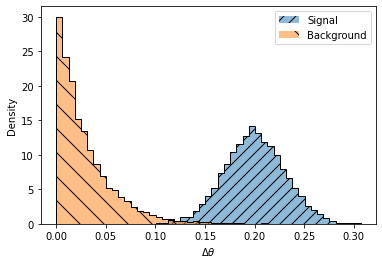

In [18]:
try:
    plotFeature(X_train, Y_train, 'theta')
except:
    pass

In [19]:
try:
    plotFeature(X_train, Y_train, 'z')
except:
    pass

In [20]:
try:
    plotFeature(X_train, Y_train, 'radii')
except:
    pass

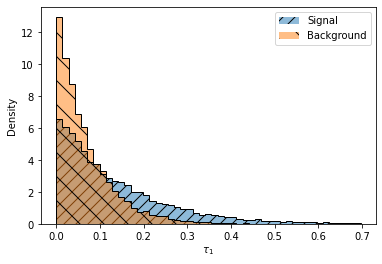

In [21]:
try:
    plotFeature(X_train, Y_train, 'tau1')
except:
    pass

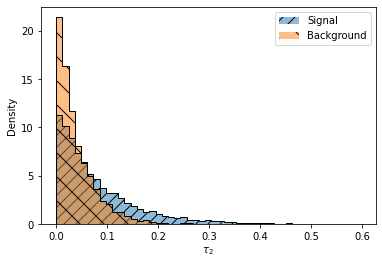

In [22]:
try:
    plotFeature(X_train, Y_train, 'tau2')
except:
    pass

## Signal difference adversary
Note: This is not currently used as an input

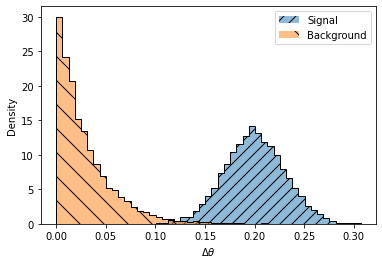

In [23]:
plotFeature(X_train, Y_train, 'theta')

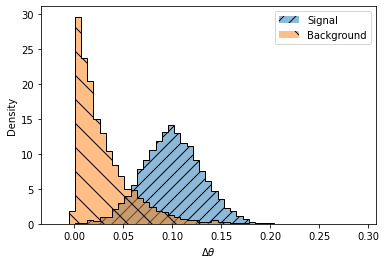

In [24]:
plotFeature(X_train_shift, Y_train_shift, 'theta')

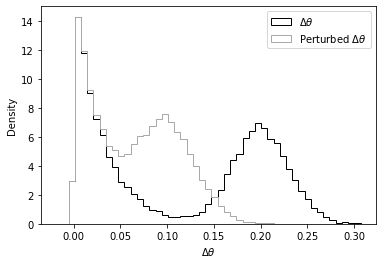

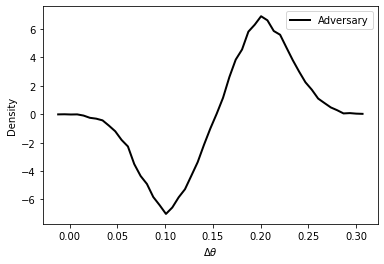

In [25]:
X_adv, Y_adv = getAdversary(X_train['theta'], X_train_shift['theta'], Y_train)

## Bin $\Delta \theta$
`binned_theta` is an input to the adversary model and
`theta_labels` are the labels for the adversary model

In [26]:
# reshape theta
X_train['theta'] = X_train['theta'][:,0]

thetabins = np.linspace(0, 0.3, HPARAMS.thetaBins)
binned_theta = np.digitize(X_train['theta'], thetabins) - 1
theta_labels = tf.one_hot(binned_theta.squeeze(), HPARAMS.thetaBins)

In [27]:
print('\nfirst 5 bins\n')
print(binned_theta[:5])
print('\nfirst 5 labels\n')
print(theta_labels.numpy()[:5])


first 5 bins

[3 0 2 3 2]

first 5 labels

[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


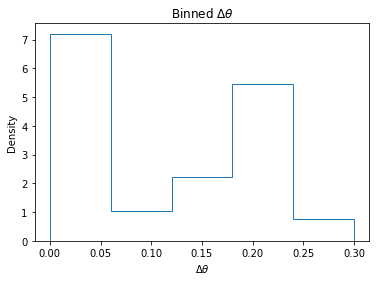

In [28]:
plt.hist(X_train['theta'].flatten(), bins=thetabins, histtype='step', density=True)
plt.xlabel(r'$\Delta \theta$')
plt.ylabel('Density')
plt.title(r'Binned $\Delta \theta$')
plt.show()

## Classifier and Adversary Training Loop



### Initialize Datasets

In [29]:
# Proportion of data to train and validate
prop_train = 0.90 
prop_validate = 1 - prop_train 

if prop_train == 0:
    print('You need to train on data.')
    prop_train = 0.50
    prop_validate = 0.50
    
if prop_validate == 0:
    print('You need to validate.')
    prop_train = 0.50
    prop_validate = 0.50

In [30]:
max_size = Y_train.shape[0]

In [31]:
X_train_ = {key: X_train[key][:int(max_size*prop_train)] for key in X_train.keys()}
Y_train_ = Y_train[:int(max_size*prop_train)]

X_validate = {key: X_train[key][int(max_size*prop_train):] for key in X_train.keys()}
Y_validate = Y_train[int(max_size*prop_train):]

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_, Y_train_))
train_dataset = train_dataset.batch(HPARAMS.batchsize)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_validate, Y_validate))
valid_dataset = valid_dataset.batch(HPARAMS.batchsize)

In [33]:
theta_labels_ = theta_labels[:int(max_size*prop_train)]
theta_labels_valid = theta_labels[int(max_size*prop_train):]

In [34]:
train_dataset_adv = tf.data.Dataset.from_tensor_slices((X_train_['theta'], theta_labels_))
train_dataset_adv = train_dataset_adv.batch(HPARAMS.batchsize)

valid_dataset_adv = tf.data.Dataset.from_tensor_slices((X_validate['theta'], theta_labels_valid))
valid_dataset_adv = valid_dataset_adv.batch(HPARAMS.batchsize)

In [35]:
loss_class_fn = tf.keras.losses.CategoricalCrossentropy()
loss_adv_fn = tf.keras.losses.CategoricalCrossentropy()

class_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
adv_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


optimizer_class=tf.keras.optimizers.Adam(lr=HPARAMS.classifier_lr)
optimizer_adv=tf.keras.optimizers.Adam(lr=HPARAMS.adversary_lr)
optimizer=tf.keras.optimizers.Adam(lr=HPARAMS.classifier_lr)

/usr/local/jupyter/lib64/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
train_dataset_theta = [element[0]['theta'] for element in train_dataset]
train_dataset_theta_Y = [element[1] for element in train_dataset_adv]

valid_dataset_theta = [element[0]['theta'] for element in valid_dataset]
valid_dataset_theta_Y = [element[1] for element in valid_dataset_adv]

## Custom Loss Function and Custom Gradients

### Combined loss of classifier and adversary

$$ \mathcal{L}_{total} = \mathcal{L}_{classifier} - \lambda \mathcal{L}_{adversary} $$ 

In [37]:
print('lambda = {}'.format(HPARAMS.Lambda))

lambda = 10


### Custom Loss Function

In [38]:


def calc_loss_total(loss_c, loss_a):

    # loss_c  - loss of classifier
    # loss_a  - loss of adversary
    
    loss_c = tf.cast(loss_c, 'float32')
    loss_a = tf.cast(loss_a, 'float32')

    L = tf.math.abs(tf.reduce_mean(loss_c - HPARAMS.Lambda * loss_a))
    
    return L
    
    
    
    
    
    

## Build and combine models

### Inputs for classifier model

In [39]:
classifier_inputs = []
xlayers = []

n = len(layer_names)

for i in range(n):

    if('theta' in layer_names[i]):
        
        inpt = tf.keras.Input(shape = (1,), name=layer_names[i])

        x = tf.keras.layers.Flatten()(inpt)
        classifier_inputs.append(inpt)
        xlayers.append(x)

        x_dense = tf.keras.layers.Dense(64, activation='relu')(x)
        xlayers.append(x_dense)

    else:

        inpt = tf.keras.Input(shape = (10,1), name=layer_names[i])
        x = tf.keras.layers.Flatten()(inpt)

        classifier_inputs.append(inpt)
        xlayers.append(x) 

if(n > 1):
    concatenated_layers_classifier = tf.keras.layers.concatenate(inputs=xlayers, axis=-1)

if(n==1):
    classifier_inputs = classifier_inputs[0]

classifier_inputs_dict = {c.name:c for c in classifier_inputs}

### Inputs for adversary model

In [40]:
input_from_model = tf.keras.layers.Input(shape = (2,), name='Input')
x_input = tf.keras.layers.Flatten()(input_from_model)

feature_input = tf.keras.layers.Input(shape = (1,), name='theta_2')
x_feature = tf.keras.layers.Flatten()(feature_input)

concatenated_layers_adv = tf.keras.layers.concatenate(inputs=[x_feature,x_input], axis=-1)
adversary_inputs = [input_from_model, x_feature]

## Build Classifier and Adversary

In [41]:
classifier = build_classifier(classifier_inputs, concatenated_layers_classifier)
adversary = build_adversary(adversary_inputs, concatenated_layers_adv)

classifier_output = classifier(classifier_inputs)
adversary_output = adversary(adversary_inputs)

## Build Combined Model

In [42]:
model_inputs = {**classifier_inputs_dict,
            'Input':input_from_model,
            'theta_2':feature_input,
    }
model_inputs

{'theta': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'theta')>,
 'tau1': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'tau1')>,
 'tau2': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'tau2')>,
 'Input': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'Input')>,
 'theta_2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'theta_2')>}

In [43]:
model = tf.keras.Model(
    inputs=model_inputs,
    outputs={'c_out':classifier_output,
             'a_out':adversary_output,
            },
    
    name='Classifier_and_Adversary',
    
)

In [44]:
model.summary()

Model: "Classifier_and_Adversary"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input (InputLayer)              [(None, 2)]          0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 1)            0           theta_2[0][0]                    
__________________________________________________________________________________________________
theta (InputLayer)              [(None, 1)]          0                                            
___________________________________________________________________________

## Custom Training

Train adversary for 20 epochs

In [45]:

classifier.compile(
    loss=loss_class_fn,
    optimizer=optimizer_class,
)

adversary.compile(
    loss=loss_adv_fn,
    optimizer=optimizer_adv,
)

model.compile(optimizer=optimizer)

In [46]:

classifierEpochs = 1
adversaryEpochs=20

if(classifierOnly):
    classifierEpochs = 10

### Train Classifier

In [47]:
classifier.fit(X_train_, Y_train_, epochs=classifierEpochs)

563/563 [==============================] - 1s 2ms/step - loss: 0.0855


### Train Adversary

In [48]:

if(not classifierOnly):
    adversary.fit([classifier(X_train_), X_train_['theta']], theta_labels_, epochs=adversaryEpochs)

Epoch 1/20
563/563 [==============================] - 1s 1ms/step - loss: 0.6473
Epoch 2/20
563/563 [==============================] - 1s 1ms/step - loss: 0.3917
Epoch 3/20
563/563 [==============================] - 1s 1ms/step - loss: 0.2101
Epoch 4/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1448
Epoch 5/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1150
Epoch 6/20
563/563 [==============================] - 1s 1ms/step - loss: 0.0996
Epoch 7/20
563/563 [==============================] - 1s 1ms/step - loss: 0.0908
Epoch 8/20
563/563 [==============================] - 1s 1ms/step - loss: 0.0826
Epoch 9/20
563/563 [==============================] - 1s 1ms/step - loss: 0.0781
Epoch 10/20
563/563 [==============================] - 1s 1ms/step - loss: 0.0700
Epoch 11/20
563/563 [==============================] - 1s 1ms/step - loss: 0.0689
Epoch 12/20
563/563 [==============================] - 1s 1ms/step - loss: 0.0591
Epoch 13/20
563/563 [====

## Training Loop

In [49]:
# to not get thousands of warnings about gradients
tf.get_logger().setLevel('ERROR')

In [50]:
valid_dataset

<BatchDataset shapes: ({theta: (None,), tau1: (None, 10), tau2: (None, 10)}, (None, 2)), types: ({theta: tf.float64, tau1: tf.float64, tau2: tf.float64}, tf.float64)>

In [51]:
metrics = {}
metrics['loss_class'] = list([])
metrics['loss_adv'] = list([])
metrics['loss_total'] = list([])
metrics['acc_class'] = list([])
metrics['acc_adv'] = list([])

In [52]:
def train_model(HPARAMS, classifier, adversary, train_dataset, valid_dataset, 
                X_train, Y_train, theta_labels, classifierOnly = classifierOnly):
    
    metrics = {}
    
    metrics['loss_class'] = list([])
    metrics['loss_adv'] = list([])
    metrics['loss_total'] = list([])
    metrics['acc_class'] = list([])
    metrics['acc_adv'] = list([])
    
    loss_class_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_adv_fn = tf.keras.losses.CategoricalCrossentropy()

    class_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    adv_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    optimizer_class=tf.keras.optimizers.Adam(lr=HPARAMS.classifier_lr)
    optimizer_adv=tf.keras.optimizers.Adam(lr=HPARAMS.adversary_lr)
    optimizer=tf.keras.optimizers.Adam(lr=HPARAMS.classifier_lr)

    if (not classifierOnly):

        toPrint=True
        last_epoch=time.time()
        start_training = time.time()
        total_epochs=1


        nEpochs = 1

        nUpdates_Classifier = HPARAMS.nUpdates_Classifier

        for ii in range(nEpochs):

            start_update=time.time()

            for epoch in range(nUpdates_Classifier):

                for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

                    ### TRAIN CLASSIFIER ###

                    with tf.GradientTape(persistent=True) as tape_class:

                        # adversary output and labels for the batch
                        logits_adv = adversary([classifier(x_batch_train), train_dataset_theta[step]])
                        preds_adv = train_dataset_theta_Y[step]

                        # classifier output for the batch
                        logits_class = classifier(x_batch_train) 

                        # get classifier loss
                        loss_class = loss_class_fn(logits_class, y_batch_train)

                        # get adversary loss
                        loss_adv = loss_class_fn(logits_adv, preds_adv)
                        tape_class.watch(loss_class)

                        # get combined loss
                        loss_total = calc_loss_total(loss_class, loss_adv)



                        tape_class.watch(loss_total)
                        tape_class.watch(model.trainable_weights)

                        # get gradients
                        grads = tape_class.gradient(loss_total, model.trainable_weights)            

                        # apply gradients
                        optimizer.apply_gradients(zip(grads, model.trainable_weights))

                        tape_class.reset()

                for step, (x_batch, y_batch) in enumerate(valid_dataset):

                    val_logits = classifier(x_batch, training = False)
                    
                    class_acc_metric.update_state(y_batch, val_logits)

#                     acc_cls = (y_batch.numpy() == np.round(val_logits.numpy())).sum()
#                     acc_cls /= (val_logits.shape[0]*val_logits.shape[1])
#                     tot_acc_cls += acc_cls


                    val_logits = adversary([classifier(x_batch), x_batch['theta']])

    #                 acc_adv = (y_batch.numpy() == np.round(val_logits.numpy()))
    #                 acc_adv /= (val_logits.shape[0]*val_logits.shape[1])
    #                 tot_acc_adv += acc_adv




                metrics['acc_class'].append(class_acc_metric.result().numpy())
                class_acc_metric.reset_states()
                #metrics['adv_acc'].append(tot_acc_adv/(step + 1))

                if(toPrint):


                    loss_adv = loss_adv_fn(adversary([classifier(X_train), X_train['theta']]), theta_labels)
                    loss_class = loss_class_fn(classifier(X_train), Y_train)

                    loss_total = calc_loss_total(loss_class, loss_adv)

                    print("\nEpoch %d" % (total_epochs,))
                    printTime(time.time() - last_epoch)
                    print('L_class', loss_class.numpy())
                    print('L_adv', loss_adv.numpy())
                    print('L_total', loss_total.numpy())
                    last_epoch = time.time()

                    metrics['loss_class'].append(loss_class.numpy())
                    metrics['loss_adv'].append(loss_adv.numpy())
                    metrics['loss_total'].append(loss_total.numpy())

                    total_epochs += 1




            end_update = time.time()
            printTime(end_update - start_update)



            print()

        print()
        end_training=time.time()
        print('\nTotal time: ', end='')
        printTime(end_training - start_training)
        
    return metrics

In [53]:
metrics = train_model(HPARAMS, classifier, adversary, train_dataset, valid_dataset, 
                X_train_, Y_train_, theta_labels_)


Epoch 1
Time 9.93s
L_class 0.7690088152885437
L_adv 0.6663775
L_total 5.8947663

Epoch 2
Time 10.24s
L_class 3.50907301902771
L_adv 0.4998182
L_total 1.4891093

Epoch 3
Time 10.10s
L_class 4.327120780944824
L_adv 0.54213613
L_total 1.0942407

Epoch 4
Time 10.22s
L_class 4.776030540466309
L_adv 0.52550215
L_total 0.47899103
Time 40.49s



Total time: Time 40.49s


In [54]:
HPARAMS.Lambda

10

In [55]:
metrics

{'loss_class': [0.7690088152885437,
  3.50907301902771,
  4.327120780944824,
  4.776030540466309],
 'loss_adv': [0.6663775, 0.4998182, 0.54213613, 0.52550215],
 'loss_total': [5.8947663, 1.4891093, 1.0942407, 0.47899103],
 'acc_class': [0.9895, 0.99, 0.553, 0.501],
 'acc_adv': []}

## Save Models

In [56]:
# create model names 

model_string = ''
for name in layer_names:
    model_string += '_' + name
if(classifierOnly):
    model_string += '_classifierOnly'
model_name = 'model' + model_string
model_string

'_theta_tau1_tau2'

In [57]:
# save models 

tf.keras.models.save_model(model, f'models/{model_string}.h5')
print('saving '+'models/'+model_name+'.h5')
if (not classifierOnly):
    tf.keras.models.save_model(classifier, f'models/{model_name}_classifier.h5')
    tf.keras.models.save_model(adversary, f'models/{model_name}_adversary.h5')

    print(f'saving models/{model_name}_classifier.h5')
    print(f'saving models/{model_name}_adversary.h5')

saving models/model_theta_tau1_tau2.h5
saving models/model_theta_tau1_tau2_classifier.h5
saving models/model_theta_tau1_tau2_adversary.h5


# Plots

## Loss

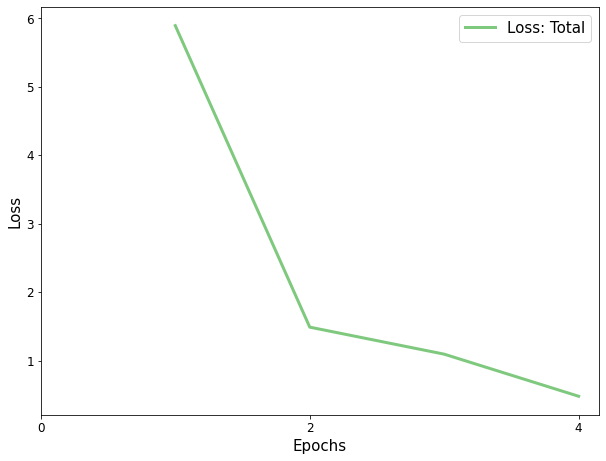

In [58]:
fig = plt.figure(figsize=(10,7.5))
x_epochs = np.arange(len(metrics['loss_total']), dtype=int) + 1

lw=3

cmap = plt.get_cmap('Accent')
colors = np.linspace(0,1,9)
plt.plot(x_epochs, metrics['loss_total'], lw=lw, color=cmap(colors[0]), label='Loss: Total')
# plt.plot(x_epochs, metrics['loss_class'], lw=lw, color=cmap(colors[1]), label='Loss: Classifier')
# plt.plot(x_epochs, HPARAMS.Lambda*np.array(metrics['loss_adv']), lw=lw, color=cmap(colors[2]), label='Loss: Adversary')
plt.legend(fontsize=15)
# plt.ylim(-0.1,10.1)
plt.xticks(np.linspace(0,(len(metrics['loss_total']) + len(metrics['loss_total'])%2),1+(len(metrics['loss_total']) + len(metrics['loss_total'])%2)//2, dtype=int), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.show()

### Variable dictionaries for plotting

In [59]:
xvars = {name:X_train[name].squeeze() for name in layer_names}

for key in xvars.keys():
    
    if(len(xvars[key].shape) > 1):
        xvars[key] = np.average(xvars[key], axis=1)
        

### Get Model Predictions

In [60]:
predict = classifier(X_train)
predict_adv = adversary([predict, X_train['theta']])

### Uncomment to load saved models instead

In [61]:
# loaded_model = tf.keras.models.load_model('models/model_theta_tau1_tau2.h5')
# loaded_classifier = tf.keras.models.load_model('models/model_theta_tau1_tau2_classifier.h5')
# loaded_adversary = tf.keras.models.load_model('models/model_theta_tau1_tau2_adversary.h5')

# predict = loaded_classifier(X_train)
# predict_adv = loaded_adversary([predict, X_train['theta']])

## Predictions

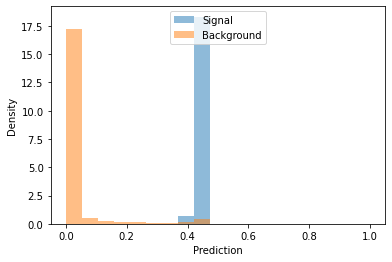

In [62]:
sig = predict[Y_train[:,1]==1][:,1].numpy()
bkg = predict[Y_train[:,0]==1][:,1].numpy()

bins = np.linspace(0, 1, 20)

plt.hist(sig, bins, alpha=0.5, label='Signal', density=True)
plt.hist(bkg, bins, alpha=0.5, label='Background', density=True)
# plt.ylim(0,25000)
# plt.yscale('log')
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.show()

## Plot Model Response

saving plots/Lambda10_scatterplots.png


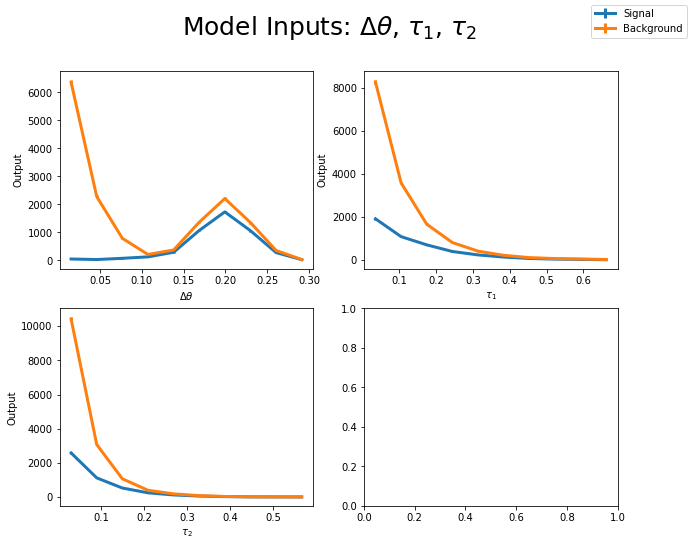

In [63]:
rows = Nlist // 2 + Nlist % 2
cols = 2
fig, ax = plt.subplots(rows,cols, figsize=(10,4*rows))

Title = 'Model Inputs:'
for name in layer_names:
    Title += ', ' + xlabels[name]
    
Title = Title.replace(':,', ':')



xvals_list = []
yvals_list = []
yerrs_list = []

xvals_list_bkg = []
yvals_list_bkg = []
yerrs_list_bkg = []

for name in layer_names:
    
    x, y, e = get_prediction_yvalues(xvars[name], predict[:,1])
    xb, yb, eb = get_prediction_yvalues(xvars[name], predict[:,0])
    
    xvals_list.append(x)
    yvals_list.append(y)
    yerrs_list.append(e)

    xvals_list_bkg.append(xb)
    yvals_list_bkg.append(yb)
    yerrs_list_bkg.append(eb)
    
    
    
if (Nlist > 0):
    if(Nlist < 2):
        ax1 = ax[0]
    elif(Nlist < 3):
        ax1 = ax[0]
    else:
        ax1 = ax[0][0]
        
        
if (Nlist > 1):
    if(Nlist < 3):
        ax2 = ax[1]
    else:
        ax2 = ax[0][1]
        

if (Nlist > 2): ax3 = ax[1][0]
if (Nlist > 3): ax4 = ax[1][1]
if (Nlist > 4): ax5 = ax[2][0]
if (Nlist > 5): ax6 = ax[2][1]
    
    
fmt = ''
lw = 3

if (Nlist > 0):
    
    ax1.errorbar(xvals_list[0], yvals_list[0], yerr=yerrs_list[0], lw=lw, fmt=fmt)
    ax1.errorbar(xvals_list_bkg[0], yvals_list_bkg[0], yerr=yerrs_list_bkg[0], lw=lw, fmt=fmt)
    ax1.set_xlabel(xlabels[layer_names[0]])
    ax1.set_ylabel(r'Output')    
    
if (Nlist > 1):
    
    ax2.errorbar(xvals_list[1], yvals_list[1], yerr=yerrs_list[1], lw=lw, fmt=fmt)
    ax2.errorbar(xvals_list_bkg[1], yvals_list_bkg[1], yerr=yerrs_list_bkg[1], lw=lw, fmt=fmt)
    ax2.set_xlabel(xlabels[layer_names[1]])
    ax2.set_ylabel(r'Output')
    
if (Nlist > 2):
    
    ax3.errorbar(xvals_list[2], yvals_list[2], yerr=yerrs_list[2], lw=lw, fmt=fmt)
    ax3.errorbar(xvals_list_bkg[2], yvals_list_bkg[2], yerr=yerrs_list_bkg[2], lw=lw, fmt=fmt)
    ax3.set_xlabel(xlabels[layer_names[2]])
    ax3.set_ylabel(r'Output')

if (Nlist > 3):
    
    ax4.errorbar(xvals_list[3], yvals_list[3], yerr=yerrs_list[3], lw=lw, fmt=fmt)
    ax4.errorbar(xvals_list_bkg[3], yvals_list_bkg[3], yerr=yerrs_list_bkg[3], lw=lw, fmt=fmt)
    ax4.set_xlabel(xlabels[layer_names[3]])
    ax4.set_ylabel(r'Output')
    
if (Nlist > 4):
    
    ax5.errorbar(xvals_list[4], yvals_list[4], yerr=yerrs_list[4], lw=lw, fmt=fmt)
    ax5.errorbar(xvals_list_bkg[4], yvals_list_bkg[4], yerr=yerrs_list_bkg[4], lw=lw, fmt=fmt)
    ax5.set_xlabel(xlabels[layer_names[4]])
    ax5.set_ylabel(r'Output')
    
if (Nlist > 5):
    
    ax6.errorbar(xvals_list[5], yvals_list[5], yerr=yerrs_list[5], lw=lw, fmt=fmt)
    ax6.errorbar(xvals_list_bkg[5], yvals_list_bkg[5], yerr=yerrs_list_bkg[5], lw=lw, fmt=fmt)
    ax6.set_xlabel(xlabels[layer_names[5]])
    ax6.set_ylabel(r'Output')   

fig.legend(['Signal', 'Background'])




figname = 'plots/Lambda'+str(HPARAMS.Lambda)+'_scatterplots.png'
plt.savefig(figname)
print('saving '+figname)

plt.suptitle(Title, fontsize=25)
# plt.tight_layout()


plt.show()

saving plots/Lambda10_scatterplots_norm.png


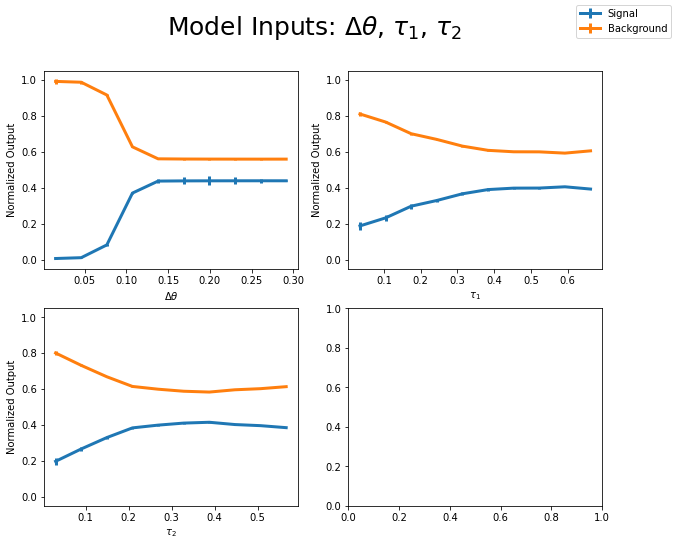

In [64]:
fig, ax = plt.subplots(rows,cols, figsize=(10,4*rows))

plt.suptitle(Title, fontsize=25)

xvals_list = []
yvals_list = []
yerrs_list = []

xvals_list_bkg = []
yvals_list_bkg = []
yerrs_list_bkg = []


yrange = [-0.05,1.05]

for name in layer_names:
    
    x, y, e = get_prediction_yvalues(xvars[name], predict[:,1], norm=True)
    xb, yb, eb = get_prediction_yvalues(xvars[name], predict[:,0], norm=True)
    
    xvals_list.append(x)
    yvals_list.append(y)
    yerrs_list.append(e)

    xvals_list_bkg.append(xb)
    yvals_list_bkg.append(yb)
    yerrs_list_bkg.append(eb)
    
    
    
if (Nlist > 0):
    if(Nlist < 2):
        ax1 = ax[0]
    elif(Nlist < 3):
        ax1 = ax[0]
    else:
        ax1 = ax[0][0]
        
        
if (Nlist > 1):
    if(Nlist < 3):
        ax2 = ax[1]
    else:
        ax2 = ax[0][1]
        

if (Nlist > 2): ax3 = ax[1][0]
if (Nlist > 3): ax4 = ax[1][1]
if (Nlist > 4): ax5 = ax[2][0]
if (Nlist > 5): ax6 = ax[2][1]

if (Nlist > 0):
    
    ax1.errorbar(xvals_list[0], yvals_list[0], yerr=yerrs_list[0], lw=lw, fmt=fmt)
    ax1.errorbar(xvals_list_bkg[0], yvals_list_bkg[0], yerr=yerrs_list_bkg[0], lw=lw, fmt=fmt)
    ax1.set_xlabel(xlabels[layer_names[0]])
    ax1.set_ylabel(r'Normalized Output')
    ax1.set_ylim(yrange)
    
if (Nlist > 1):
    
    ax2.errorbar(xvals_list[1], yvals_list[1], yerr=yerrs_list[1], lw=lw, fmt=fmt)
    ax2.errorbar(xvals_list_bkg[1], yvals_list_bkg[1], yerr=yerrs_list_bkg[1], lw=lw, fmt=fmt)
    ax2.set_xlabel(xlabels[layer_names[1]])
    ax2.set_ylabel(r'Normalized Output')
    ax2.set_ylim(yrange)
    
if (Nlist > 2):
    
    ax3.errorbar(xvals_list[2], yvals_list[2], yerr=yerrs_list[2], lw=lw, fmt=fmt)
    ax3.errorbar(xvals_list_bkg[2], yvals_list_bkg[2], yerr=yerrs_list_bkg[2], lw=lw, fmt=fmt)
    ax3.set_xlabel(xlabels[layer_names[2]])
    ax3.set_ylabel(r'Normalized Output')
    ax3.set_ylim(yrange)

if (Nlist > 3):
    
    ax4.errorbar(xvals_list[3], yvals_list[3], yerr=yerrs_list[3], lw=lw, fmt=fmt)
    ax4.errorbar(xvals_list_bkg[3], yvals_list_bkg[3], yerr=yerrs_list_bkg[3], lw=lw, fmt=fmt)
    ax4.set_xlabel(xlabels[layer_names[3]])
    ax4.set_ylabel(r'Normalized Output')
    ax4.set_ylim(yrange)
    
if (Nlist > 4):
    
    ax5.errorbar(xvals_list[4], yvals_list[4], yerr=yerrs_list[4], lw=lw, fmt=fmt)
    ax5.errorbar(xvals_list_bkg[4], yvals_list_bkg[4], yerr=yerrs_list_bkg[4], lw=lw, fmt=fmt)
    ax5.set_xlabel(xlabels[layer_names[4]])
    ax5.set_ylabel(r'Normalized Output')
    ax5.set_ylim(yrange)
    
if (Nlist > 5):
    
    ax6.errorbar(xvals_list[5], yvals_list[5], yerr=yerrs_list[5], lw=lw, fmt=fmt)
    ax6.errorbar(xvals_list_bkg[5], yvals_list_bkg[5], yerr=yerrs_list_bkg[5], lw=lw, fmt=fmt)
    ax6.set_xlabel(xlabels[layer_names[5]])
    ax6.set_ylabel(r'Normalized Output')
    ax6.set_ylim(yrange)

fig.legend(['Signal', 'Background'])
# plt.tight_layout()



figname = 'plots/Lambda'+str(HPARAMS.Lambda)+'_scatterplots_norm.png'
plt.savefig(figname)
print('saving '+figname)

plt.show()

## Plot Adversary Output

plotting bin 1
plotting bin 2
plotting bin 3
plotting bin 4
plotting bin 5
plotting bin 6
saving plots/Adversary_Output.png


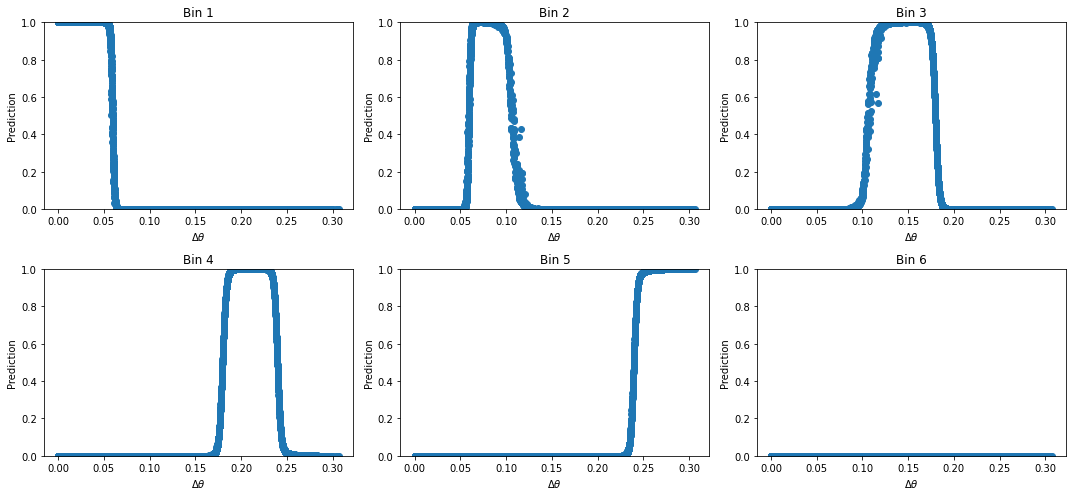

In [65]:
rows=2
cols=3

fig, ax = plt.subplots(rows,cols, figsize=(15,7))

if(HPARAMS.thetaBins > 0): plotBin(1, xvars['theta'], predict_adv, rows, cols)
if(HPARAMS.thetaBins > 1): plotBin(2, xvars['theta'], predict_adv, rows, cols)
if(HPARAMS.thetaBins > 2): plotBin(3, xvars['theta'], predict_adv, rows, cols)
if(HPARAMS.thetaBins > 3): plotBin(4, xvars['theta'], predict_adv, rows, cols)
if(HPARAMS.thetaBins > 4): plotBin(5, xvars['theta'], predict_adv, rows, cols)
if(HPARAMS.thetaBins > 5): plotBin(6, xvars['theta'], predict_adv, rows, cols)

plt.tight_layout()
figname = 'plots/Adversary_Output.png'
plt.savefig(figname)
print('saving '+figname)
plt.show()

In [66]:
printTime(time.time()-start_notebook)

Time 1m 7.64s
